In [1421]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import robust_scale
import matplotlib.pyplot as plt

from umap import UMAP
from hdbscan import HDBSCAN
import matplotlib.colors as colors

sns.set_theme(context="notebook", style="darkgrid")
random_state = 42

### Task
Target: Need to perform clustering to summarize customer segments.  
Data source and description: https://www.kaggle.com/imakash3011/customer-personality-analysis

Load data

In [1422]:
data = pd.read_csv(
    filepath_or_buffer="data\\marketing_campaign.csv", 
    sep="\t", 
    parse_dates=["Dt_Customer", "Year_Birth"]
)

data = data.fillna(0)

### Extract Features
- Convert maritial status to four categories
- Combine "kids" and "teens" columns
- Convert Costumer age to integer
- Clip unrealistic values for year born and income

In [1423]:
data.set_index("ID", inplace=True)
data.replace(
    to_replace={
        "YOLO": "Single",
        "Absurd": "Single",
        "Alone": "Single",
        "Together": "Married"},
        inplace=True
)

data_original = data.copy()
data.Year_Birth = np.clip(data.Year_Birth, "1940", "2020")
data["Year_Birth_int"] = data.Year_Birth.view("int64")
data["Dt_Customer_int"] = data["Dt_Customer"].view("int64")

data["NumAcceptedTotal"] = data.loc[:,"AcceptedCmp3":"AcceptedCmp2"].sum(axis=1)
data.Kidhome += data["Teenhome"]
data.drop(["Teenhome", "Z_CostContact", "Z_Revenue", "Year_Birth", "Dt_Customer", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"], axis=1, inplace=True)
data.Income = np.clip(data.Income, 10_000, 150_000)

Calculate total amount of money spent

In [1424]:
money_spent_total = (
    data["MntWines"] +
    data["MntFruits"] +
    data["MntMeatProducts"] + 
    data["MntFishProducts"] + 
    data["MntSweetProducts"] + 
    data["MntGoldProds"]
)

Encode categorical features

In [1425]:
Education_categories = ["Basic", "Graduation", "2n Cycle", "Master", "PhD"]

ordinal_enc = OrdinalEncoder(
    categories=[Education_categories],
    dtype="int"
)

oh_enc = OneHotEncoder(
    sparse=False,
    dtype="int"
)

education_ordinal = pd.DataFrame(ordinal_enc.fit_transform(
    X=np.array(data.Education).reshape(-1, 1))).set_index(data.index)

Marital_Status_binary = pd.DataFrame(oh_enc.fit_transform(
    X=np.array(data["Marital_Status"]).reshape(-1, 1)), columns=data.Marital_Status.unique()).set_index(data.index)

data = pd.concat([data, education_ordinal, Marital_Status_binary], axis=1)
data = data.drop(labels=["Education", "Marital_Status"], axis=1)
data_columns = data.columns
# data = robust_scale(data)

### Select useful features

In [1426]:
model = VarianceThreshold(0.2)
data = robust_scale(data)
data = model.fit_transform(data)
data_columns = model.get_feature_names_out(data_columns)

EDA

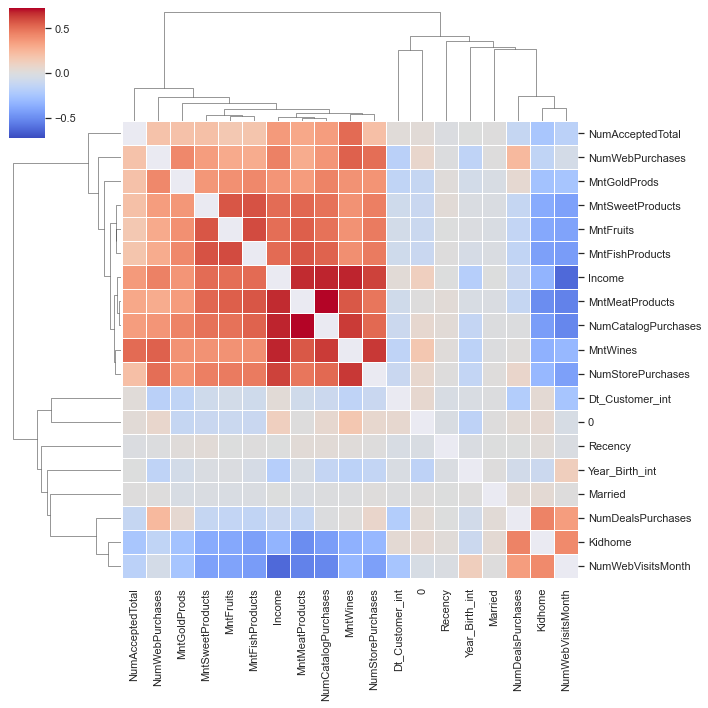

In [1427]:
mask=np.identity(len(data_columns))
sns.clustermap(
    pd.DataFrame(data, columns=data_columns).corr(),
    metric="correlation",
    mask=mask,
    cmap="coolwarm",
    # z_score=1,
    norm=colors.CenteredNorm(),
    linewidths=0.5
)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, 'Income'),
  Text(1.5, 0, 'Kidhome'),
  Text(2.5, 0, 'Recency'),
  Text(3.5, 0, 'MntWines'),
  Text(4.5, 0, 'MntFruits'),
  Text(5.5, 0, 'MntMeatProducts'),
  Text(6.5, 0, 'MntFishProducts'),
  Text(7.5, 0, 'MntSweetProducts'),
  Text(8.5, 0, 'MntGoldProds'),
  Text(9.5, 0, 'NumDealsPurchases'),
  Text(10.5, 0, 'NumWebPurchases'),
  Text(11.5, 0, 'NumCatalogPurchases'),
  Text(12.5, 0, 'NumStorePurchases'),
  Text(13.5, 0, 'NumWebVisitsMonth'),
  Text(14.5, 0, 'Year_Birth_int'),
  Text(15.5, 0, 'Dt_Customer_int'),
  Text(16.5, 0, 'NumAcceptedTotal'),
  Text(17.5, 0, '0'),
  Text(18.5, 0, 'Married')])

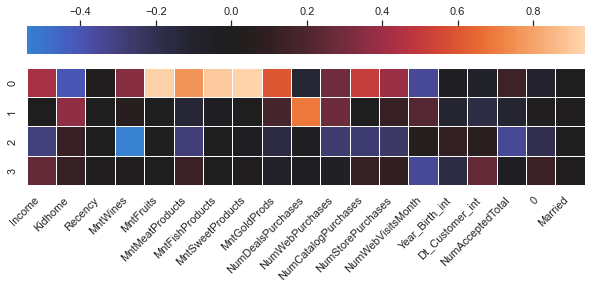

In [1647]:
fa = FactorAnalysis(
    n_components=4,
    # alpha=0.5,
    # n_jobs=-1
    rotation="varimax"
    )
fa.fit(data)

plt.figure(figsize=(10,5))
sns.heatmap(
    pd.DataFrame(fa.components_, columns=data_columns), 
    square=True,
    cbar_kws={"orientation": "horizontal",
        "location":"top"
       },
    linewidths=1,
    center=0)

plt.xticks(rotation=45, horizontalalignment="right")

### Main takeaways
- Number of Kids and number of Web Visits correlate negative with income and money spend
- Income correlates very strong positive with number of purchases and money spent on products (all categories)

### Clustering
Map to two dimensions

In [1430]:
reducer = UMAP(
    n_components=3,
    local_connectivity=1,
    min_dist=0,
    n_neighbors=50,
    densmap=True,
    metric="cosine",
    target_metric="l1",
    target_weight=0.3,
    unique=True,
    random_state=random_state
)

embedding = reducer.fit_transform(
    X=data,
    # y=robust_scale(money_spent_total)
)

Plot data

<AxesSubplot:>

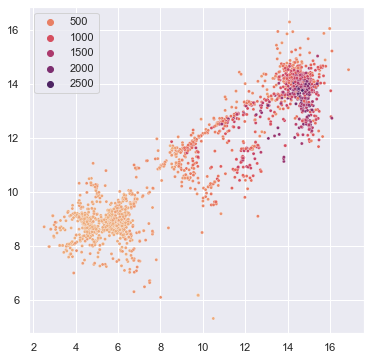

In [1431]:
plt.figure(figsize=(6,6))

sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    s=10,
    hue=money_spent_total,
    palette="flare"
)

Unsupervised clustering

In [1684]:
clusterer = HDBSCAN(
    min_cluster_size=100,
    min_samples=5,
)

clusters = clusterer.fit_predict(embedding)

### Clusteranalysis
Plot detected clusters

In [1687]:
# plt.figure(figsize=(6,6))
# sns.scatterplot(
#     x=embedding[:,0],#[clusters!=-1],
#     y=embedding[:,1],#[clusters!=-1],
#     s=10,
#     hue=clusters,#[clusters!=-1],
#     palette="deep",
#     # color="gray"
# )

In [1689]:
import plotly.express as px
fig = px.scatter_3d(pd.DataFrame(embedding), 
    x=0,
    y=1,
    z=2,
    color=clusters.astype("str"),
    # color=money_spent_total,
    )
fig.update_traces(marker_size = 2)


In [1690]:
print("Number of cusomers in each group: \n" f"{money_spent_total.groupby(clusters).count()}")
print("Money spent per cluster: \n" f"{money_spent_total.groupby(clusters).sum()}")
print("Proportion spent per cluster: \n" f"{100 * money_spent_total.groupby(clusters).sum() / money_spent_total.sum()}")

Number of cusomers in each group: 
-1    362
 0    947
 1    673
 2    258
dtype: int64
Money spent per cluster: 
-1    244441
 0     76758
 1    872098
 2    163691
dtype: int64
Proportion spent per cluster: 
-1    18.013498
 0     5.656498
 1    64.267186
 2    12.062819
dtype: float64


Results:
- Three main clusters  
    1. Large cluster, high spending  
    2. Medium cluster, medium spending  
    3. Large cluster, low spending  
- 80% of all money comes from first two clusters
- Significant part of users considered outlier

Describe Clusters

[Text(0.5, 0, 'Money spent total')]

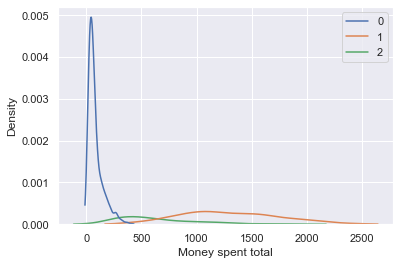

In [1692]:
plot = sns.kdeplot(
    data=data_original[clusters!=[-1]],
    x=money_spent_total[clusters!=-1],
    hue=clusters[clusters!=-1],
    # multiple="stack",
    palette="deep",
    cut=1,
    # log_scale=True
)

plot.set(xlabel="Money spent total")

<AxesSubplot:xlabel='Income', ylabel='Density'>

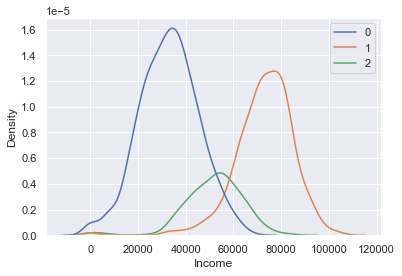

In [1693]:
sns.kdeplot(
    x=data_original[clusters!=-1].Income+1,
    hue=clusters[clusters!=-1],
    # multiple="fill",
    palette="deep",
)

<AxesSubplot:xlabel='Kidhome', ylabel='Count'>

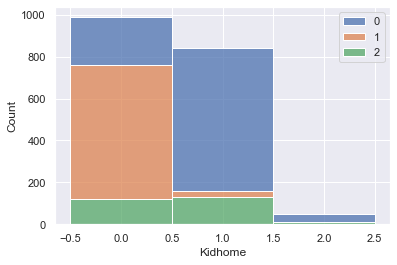

In [1707]:
sns.histplot(
    data=data_original[clusters!=-1],
    x="Kidhome",
    hue=clusters[clusters!=-1],
    multiple="stack",
    palette="deep",
    element="bars",
    discrete=True,
)

<AxesSubplot:xlabel='Education', ylabel='Count'>

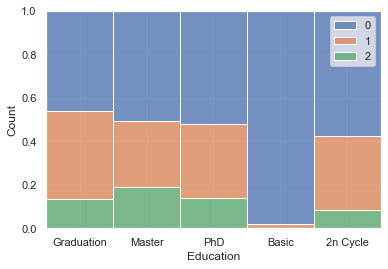

In [1709]:
sns.histplot(
    data=data_original[clusters!=-1],
    x="Education",
    hue=clusters[clusters!=-1],
    multiple="fill",
    palette="deep",
    bins=50,
    element="bars",
    discrete=True,
    # kde=True,
    # log_scale=True
)

<AxesSubplot:xlabel='Response', ylabel='Count'>

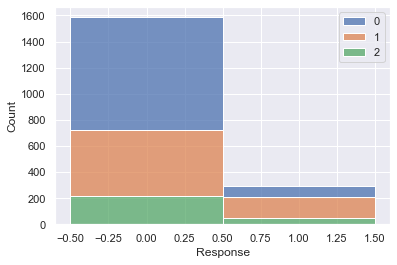

In [1710]:
sns.histplot(
    data=data_original[clusters!=-1],
    x="Response",
    hue=clusters[clusters!=-1],
    multiple="stack",
    palette="deep",
    discrete=True,
)

[Text(0.5, 0, 'Year of birth')]

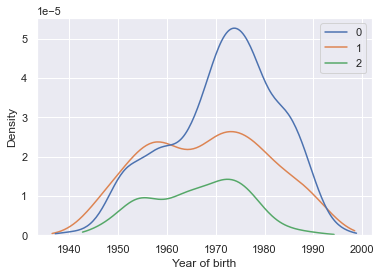

In [1792]:
import matplotlib.dates as mdates

plot = sns.kdeplot(
    x=data_original[clusters!=-1].Year_Birth.clip("1940"),
    hue=clusters[clusters!=-1],
    cut=1,
    palette="deep",
)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

plot.xaxis.set_major_locator(locator)
plot.xaxis.set_major_formatter(formatter)
plot.set(xlabel="Year of birth")

### Describe buying behavior

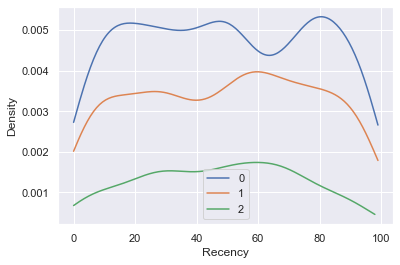

In [1793]:
plot = sns.kdeplot(
    x=data_original[clusters!=-1].Recency,
    hue=clusters[clusters!=-1],
    cut=0,
    palette="deep",
)

<AxesSubplot:xlabel='MntGoldProds', ylabel='Density'>

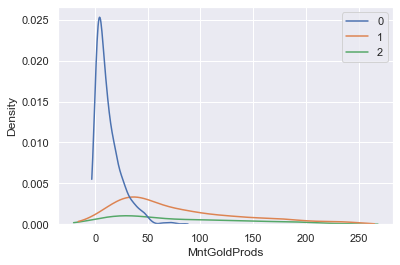

In [1699]:
sns.kdeplot(
    data=data_original[clusters!=-1],
    x="MntGoldProds",
    hue=clusters[clusters!=-1],
    cut=1,
    palette="deep",
)

<AxesSubplot:xlabel='MntWines', ylabel='Count'>

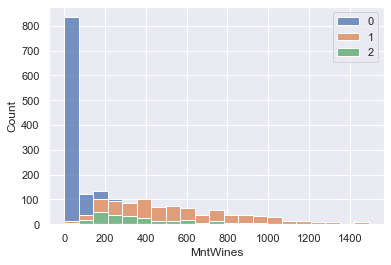

In [1701]:
sns.histplot(
    data=pd.DataFrame(data_original)[clusters!=-1],
    x="MntWines",
    hue=clusters[clusters!=-1],
    multiple="stack",
    # discrete=True,
    palette="deep",
)

[Text(0.5, 1.0, 'Average amount spent and number of purchases per cluster ')]

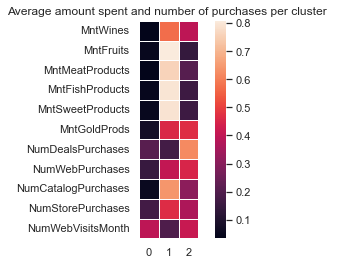

In [1773]:
cluster_groups = data_original.loc[:,"MntWines":"NumWebVisitsMonth"][clusters!=-1].groupby(clusters[clusters!=-1])

g = sns.heatmap(
    (cluster_groups.mean() / cluster_groups.mean().sum()).T,
    square=True,
    linewidths=1,
    )

g.set(title="Average amount spent and number of purchases per cluster ")

### Conclusions
- we have three distinct customer groups
- We analyzed the clusters first personal features and then the buying behavior

### Result
Group A: 
- High Income
- High spending
- No kids
- Buys from all categories
- Doesn't use Deals

Group B:
- Medium Income and medium spending
- Buys gold and wine
- uses deals
- oldest (1966 born average)
- 0 or 1 kid

Group C:
- Low income and spending
- uses website to get deals
- one kid avg